# PSD

* **author**: steeve.laquitaine@epfl.ch

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: 
    * PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * `Horvath` (aligned with cortical column)
        * rat cortex S1
        * 128ch
        * 30.0kHz
        * Horvath in vivo probe 1:
            * duration: 3606.552 (~60 mins)
        * Horvath in vivo probe 2:
            * duration: 3688.668 secs (~61 mins)
        * Horvath in vivo probe 3:
            * duration: 3603.096 secs (~60 mins)  
        * "Spontaneous activity" (Only anesthetized condition)
    * `high-density (Horvath)` (aligned with cortical column)
        * run: 2023_10_18
        * rat cortex S1
        * 384ch 
        * 40.0kHz
        * 10 min
        * "Spontaneous activity" (Only anesthetized condition)
        * fitted gain and noise + fine tuned gain
        * Silico probe 1
            * duration: 1175.9988 secs (~28 min)
        * Silico probe 2   
            * duration: 1714.99825 secs (~19 min)
        * Silico probe 3: 
            * duration: 1763.9982 secs  (~29 min)
    * `Buccino`:
        * 10 min
    * Welch method
        * 1Hz resolution, Hann window
    * The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
    and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

    $$f_r = f_s / N$$

    * We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
    * To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
    * We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).


    * Spiking band for power SNR: 300 - 6000 Hz

## Setup

1. Activate `spikeinterf..` venv

2. Compute power spectral data with: 

    ```bash
    # neuropixels (Marques & biophy. spontaneous)
    sbatch cluster/validation/psd/psd_welch_buttw_fitd_horv_10m.sbatch # 5 min
    sbatch cluster/validation/psd/psd_welch_buttw_fitd_npx_10m.sbatch # 16 min
    ```

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)


from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000          # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000          # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# SETUP DATASETS

# neuropixels *********************

# neuropixels (Marques-Smith)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["probe_wiring"]["output"]
PREP_PATH_nv = cfg_nv["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_NV = cfg_nv["validation"]["psd"]["raw"]
PRE_PSD_PATH_NV = cfg_nv["validation"]["psd"]["preprocessed"]

# neuropixels (biophy. spont.)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["40m"]["output_noise_fitd_gain_fitd_adj10perc_less_int16"]
PREP_PATH_ns = cfg_ns["preprocessing"]["output"]["40m"]["trace_file_path_gain_fitd_adj10perc_less_noise_fitd_int16"]
RAW_PSD_PATH_NS = cfg_ns["validation"]["psd"]["raw"]
PRE_PSD_PATH_NS = cfg_ns["validation"]["psd"]["preprocessed"]

# neuropixels (evoked biophy.)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["output"]
PREP_PATH_ne = cfg_ne["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_NE = cfg_ne["validation"]["psd"]["raw"]
PRE_PSD_PATH_NE = cfg_ne["validation"]["psd"]["preprocessed"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
RAW_PSD_PATH_NB = cfg_nb["validation"]["psd"]["raw"]
PRE_PSD_PATH_NB = cfg_nb["validation"]["psd"]["preprocessed"]

# custom *******************
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["probe_wiring"]["output"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["probe_wiring"]["output"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["probe_wiring"]["output"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["preprocessed"]
# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs1 = cfg_hs1["probe_wiring"]["output"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs2 = cfg_hs2["probe_wiring"]["output"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs3 = cfg_hs3["probe_wiring"]["output"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["preprocessed"]


# # neuro 


# FIGURE SETTINGS
# sampling frequency
# SFREQ_NV = 30000        
# SFREQ_NS = 40000
# SFREQ_NE = 20000
# SFREQ_NB = 32000
# SFREQ_HV = 20000        
# SFREQ_HS = 20000


# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

### Specs

In [ ]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 72
available gpus: True


['              total        used        free      shared  buff/cache   available',
 'Mem:         772341       22990      748056          88        1293      747695',
 'Swap:             0           0           0']

### (1s)Load dataset

* select first 10 min for speed

In [ ]:
# Load traces
# neuropixels
# raw
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
# preprocessed
PrepNV = si.load_extractor(PREP_PATH_nv)
PrepNS = si.load_extractor(PREP_PATH_ns)
PrepNE = si.load_extractor(PREP_PATH_ne)

# horvath
# raw (probe 1)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
# raw (probe 2)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
# raw (probe 3)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)
# preprocessed (probe 1)
PrepHV1 = si.load_extractor(PREP_PATH_hv1)
PrepHS1 = si.load_extractor(PREP_PATH_hs1)
# preprocessed (probe 2)
PrepHV2 = si.load_extractor(PREP_PATH_hv2)
PrepHS2 = si.load_extractor(PREP_PATH_hs2)
# preprocessed (probe 3)
PrepHV3 = si.load_extractor(PREP_PATH_hv3)
PrepHS3 = si.load_extractor(PREP_PATH_hs3)


# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs (in cortex)
# neuropixels
# raw
psd_raw_nv = np.load(RAW_PSD_PATH_NV, allow_pickle=True).item()
psd_raw_ns = np.load(RAW_PSD_PATH_NS, allow_pickle=True).item()
psd_raw_ne = np.load(RAW_PSD_PATH_NE, allow_pickle=True).item()
psd_raw_nb = np.load(RAW_PSD_PATH_NB, allow_pickle=True).item()
# preprocessed
psd_pre_nv = np.load(PRE_PSD_PATH_NV, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()

# custom (Horvath)
psd_raw_hv1 = np.load(RAW_PSD_PATH_HV1, allow_pickle=True).item()
psd_raw_hv2 = np.load(RAW_PSD_PATH_HV2, allow_pickle=True).item()
psd_raw_hv3 = np.load(RAW_PSD_PATH_HV3, allow_pickle=True).item()
psd_raw_hs1 = np.load(RAW_PSD_PATH_HS1, allow_pickle=True).item()
psd_raw_hs2 = np.load(RAW_PSD_PATH_HS2, allow_pickle=True).item()
psd_raw_hs3 = np.load(RAW_PSD_PATH_HS3, allow_pickle=True).item()
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_raw_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

# All Layers

## Compute

In [ ]:
# horvath vivo (all layers)
# L1 (probe 1)
psd_pre_hv1_L1 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L1["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]
# L23 (probe 1)
psd_pre_hv1_L23 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L23["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hv2_L4 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L4["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]
# L5 (probe 2)
psd_pre_hv2_L5 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L5["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_pre_hv3_L6 = copy.copy(psd_pre_hv3)
psd_pre_hv3_L6["power"] = psd_pre_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_pre_hv1_L1["power"],
        psd_pre_hv1_L23["power"],
        psd_pre_hv2_L4["power"],
        psd_pre_hv2_L5["power"],
        psd_pre_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_pre_hv1["freq"]


# horvath biophy. spont. (all layers) **************************
# L1 (probe 1)
psd_pre_hs1_L1 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L1["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_pre_hs1_L23 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L23["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hs2_L4 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L4["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_pre_hs2_L5 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L5["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_pre_hs3_L6 = copy.copy(psd_pre_hs3)
psd_pre_hs3_L6["power"] = psd_pre_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_pre_hs1_L1["power"],
        psd_pre_hs1_L23["power"],
        psd_pre_hs2_L4["power"],
        psd_pre_hs2_L5["power"],
        psd_pre_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_pre_hs1["freq"]

## Plot

NameError: name 'SFREQ_HV' is not defined

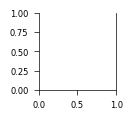

In [5]:
FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# pre panel (8 secs) --------------------------------
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "--",
    "dashes": (1, 0.5),
    "linewidth": 1.2,
    "color": (1, 0.92, 0.62),
}
pm_fit2 = {
    "linestyle": "--",
    "dashes": (1, 0.5),
    "linewidth": 1.2,
    "color": (1, 0.80, 0.62),
}

# Fit panel ************************************************************
ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, SFREQ_HV, COLOR_HV, pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_nv, alphas_spiking_nv = power.plot_fits_all(
    ax1, psd_pre_nv, SFREQ_NV, COLOR_NV, pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_pre_ns, SFREQ_NS, COLOR_NS, pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_pre_ne, SFREQ_NE, COLOR_NE, pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, SFREQ_HS, COLOR_HS, pm, pm_fit1, pm_fit2
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))


# report slopes
# lfp band
print("\nLFP band")
print(
    f"\u03B1={np.round(np.mean(alphas_lfp_hv),1)}\u00B1{np.round(np.std(alphas_lfp_hv),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_lfp_nv),1)}\u00B1{np.round(np.std(alphas_lfp_nv),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_lfp_ns),1)}\u00B1{np.round(np.std(alphas_lfp_ns),3)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_lfp_ne),1)}\u00B1{np.round(np.std(alphas_lfp_ne),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_lfp_hs),1)}\u00B1{np.round(np.std(alphas_lfp_hs),3)}"
)

# spiking band
print("\nSpiking band")
print(
    f"\u03B1={np.round(np.mean(alphas_spiking_hv),1)}\u00B1{np.round(np.std(alphas_spiking_hv),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_spiking_nv),1)}\u00B1{np.round(np.std(alphas_spiking_nv),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_spiking_ns),1)}\u00B1{np.round(np.std(alphas_spiking_ns),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_spiking_ne),1)}\u00B1{np.round(np.std(alphas_spiking_ne),1)}"
)
print(
    f"\u03B1={np.round(np.mean(alphas_spiking_hs),1)}\u00B1{np.round(np.std(alphas_spiking_hs),3)}"
)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_pre_nv["power"].shape[0]} sites""")
print(f"""n={psd_pre_ns["power"].shape[0]} sites""")
print(f"""n={psd_pre_ne["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")

# save
plt.savefig(
    "figures/0_validation/4_power/fig2p/fig2s_column_npx_pre_power_fit.svg",
    **savefig_cfg,
)


# SNR **************************
print("\nPower SNR")

out_hv = power.get_power_snr(psd_all_hv["power"], psd_all_hv["freq"], 300, 90)
out_nv = power.get_power_snr(psd_pre_nv["power"], psd_pre_nv["freq"], 300, 90)
out_ns = power.get_power_snr(psd_pre_ns["power"], psd_pre_ns["freq"], 300, 90)
out_ne = power.get_power_snr(psd_pre_ne["power"], psd_pre_ne["freq"], 300, 90)
out_hs = power.get_power_snr(psd_all_hs["power"], psd_all_hs["freq"], 300, 90)
out_nb = power.get_power_snr(psd_pre_nb["power"], psd_pre_nb["freq"], 300, 90)

### Increase in SNR

In [ ]:
# data were collected from ./psd_fits.ipynb
raw = np.array(
    [
        2.0363214301753455e-05,
        0.12849997765278076,
        0.020822604202169092,
        0.003201587790823464,
        0.03094973947782615,
        0.17805607736017218,
    ]
)
pre = np.array([14.0, 26.0, 10.0, 85.0, 229.0, 103.0])
print(pre / raw)

[6.87514250e+05 2.02334666e+02 4.80247327e+02 2.65493266e+04
 7.39909298e+03 5.78469444e+02]


# Layer 1 
* probe 1 for horvath

##### Compute data

In [11]:
layer = "L1"

# calculate stats and plot data
d = power.get_psd_data_prepro(
    layer,
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

##### Power law properties


LFP band
α=-0.5±0.0
α=-0.1±0.0
α=0.0±0.0
α=0.0±0.0
α=-0.0±0.0

Spiking band
α=-0.9±0.1
α=-0.6±0.1
α=-0.2±0.0
α=-0.1±0.0
α=-0.0±0.1

Power SNR
SNR: 29.387297633954056
SNR: 16.068638788242772
SNR: 4.694770748933799
SNR: 46.40719687604449
SNR: 134.53114339799617


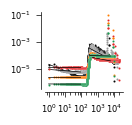

In [12]:
# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax, dd = power.plot_power_law_fits(ax, d, prm, cl, pm, pm_fit1, pm_fit2)

# save
plt.savefig("figures/0_validation/4_power/fig2O_L1_pre_power_fit.svg", **savefig_cfg)

### Stats scaling

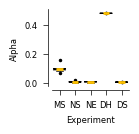

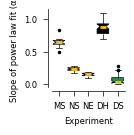

In [13]:
# LFP frequency scaling
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_lfp_freq_scaling_stats(ax, dd, cl)

# save figures
plt.savefig(
    "figures/6_supp/fig2/fig2I_L1_prepro_lfp_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Spiking frequency scaling
FIG_SIZE = (1.3, 1.25)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_spiking_freq_scaling_stats(ax, dd, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2P_L1_prepro_spiking_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

### Stats of signal power-to-noise ratio

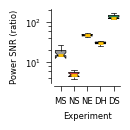

In [14]:
FIG_SIZE = (1.2, 1.2)

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_power_snr_stats(ax, d, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2Q_L1_power_snr.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Layer 2/3

### Compute

In [15]:
d23 = power.get_psd_data_prepro(
    "L2_3",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

## Power law properties


LFP band
α=-0.5±0.0
α=-0.1±0.0
α=0.0±0.0
α=0.0±0.0
α=-0.0±0.0

Spiking band
α=-1.4±0.3
α=-0.5±0.2
α=-0.3±0.1
α=-0.3±0.1
α=-0.1±0.1

Power SNR
SNR: 63.03907185529415
SNR: 18.734924823383633
SNR: 10.601102556244367
SNR: 73.78171489863517
SNR: 179.97908791744018


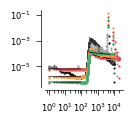

In [16]:
# plot
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax, dd23 = power.plot_power_law_fits(ax, d23, prm, cl, pm, pm_fit1, pm_fit2)

# save
plt.savefig("figures/0_validation/4_power/fig2O_L23_pre_power_fit.svg", **savefig_cfg)

## Stats scaling

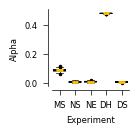

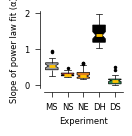

In [17]:
# LFP frequency scaling
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_lfp_freq_scaling_stats(ax, dd23, cl)
# fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/6_supp/fig2/fig2I_L23_pre_lfp_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Spiking frequency scaling
FIG_SIZE = (1.3, 1.25)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_spiking_freq_scaling_stats(ax, dd23, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2P_L23_pre_spiking_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

## Stats signal power-to-noise ratio

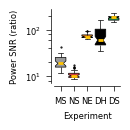

In [18]:
# plot
FIG_SIZE = (1.2, 1.2)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_power_snr_stats(ax, d23, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2Q_L23_power_snr.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Layer 4

## Compute

In [19]:
d4 = power.get_psd_data_prepro(
    "L4",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

## Power law properties


LFP band
α=-0.5±0.0
α=-0.1±0.0
α=0.0±0.0
α=0.0±0.0
α=0.0±0.0

Spiking band
α=-1.4±0.1
α=-0.4±0.1
α=-0.7±0.1
α=-0.8±0.1
α=-0.5±0.3

Power SNR
SNR: 12.8699934001426
SNR: 27.781285711348186
SNR: 31.05958399347922
SNR: 131.47135292543894
SNR: 167.2910886619861


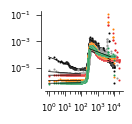

In [20]:
# plot
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax, dd4 = power.plot_power_law_fits(ax, d4, prm, cl, pm, pm_fit1, pm_fit2)

# save
plt.savefig("figures/0_validation/4_power/fig2O_L4_pre_power_fit.svg", **savefig_cfg)

## Stats scaling

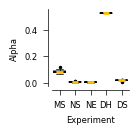

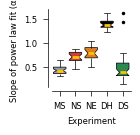

In [21]:
# LFP frequency scaling
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_lfp_freq_scaling_stats(ax, dd4, cl)

# save figures
plt.savefig(
    "figures/6_supp/fig2/fig2I_L4_pre_lfp_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Spiking frequency scaling
FIG_SIZE = (1.3, 1.25)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_spiking_freq_scaling_stats(ax, dd4, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2P_L4_pre_spiking_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

## Stats of signal power-to-noise ratio

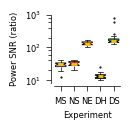

In [22]:
# plot
FIG_SIZE = (1.2, 1.2)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_power_snr_stats(ax, d4, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2Q_L4_power_snr.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Layer 5

## Compute

In [25]:
d5 = power.get_psd_data_prepro_layer_5(
    "L5",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    psd_pre_nb,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

In [231]:
# layer = "L5"

# # horvath vivo (probe 1)
# psd_pre_hv2_ = copy.copy(psd_pre_hv2)
# psd_pre_hv2_["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == layer, :]

# # biophy
# psd_pre_hs2_ = copy.copy(psd_pre_hs2)
# psd_pre_hs2_["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == layer, :]

# # neuropixels
# # vivo
# psd_pre_nv_ = copy.copy(psd_pre_nv)
# psd_pre_nv_["power"] = psd_pre_nv["power"][site_ly_nv[sites_nv] == layer, :]

# # biophy spont
# psd_pre_ns_ = copy.copy(psd_pre_ns)
# psd_pre_ns_["power"] = psd_pre_ns["power"][site_ly_ns[sites_ns] == layer, :]

# # biophy evoked
# psd_pre_ne_ = copy.copy(psd_pre_ne)
# psd_pre_ne_["power"] = psd_pre_ne["power"][site_ly_ne[sites_ne] == layer, :]


# # (11s) Divide by total power ***********************

# psd_pre_hv2_["power"] = (
#     psd_pre_hv2_["power"] / psd_pre_hv2_["power"].sum(axis=1)[:, None]
# )
# psd_pre_hs2_["power"] = (
#     psd_pre_hs2_["power"] / psd_pre_hs2_["power"].sum(axis=1)[:, None]
# )
# psd_pre_nv_["power"] = psd_pre_nv_["power"] / psd_pre_nv_["power"].sum(axis=1)[:, None]
# psd_pre_ns_["power"] = psd_pre_ns_["power"] / psd_pre_ns_["power"].sum(axis=1)[:, None]
# psd_pre_ne_["power"] = psd_pre_ne_["power"] / psd_pre_ne_["power"].sum(axis=1)[:, None]
# psd_pre_nb["power"] = psd_pre_nb["power"] / psd_pre_nb["power"].sum(axis=1)[:, None]


# # (11s) Average over sites ***********************

# # horvath
# # in vivo
# psd_mean_pre_hv2 = np.mean(psd_pre_hv2_["power"], axis=0)
# # biophy
# psd_mean_pre_hs2 = np.mean(psd_pre_hs2_["power"], axis=0)

# # neuropixels
# # pre
# psd_mean_pre_nv = np.mean(psd_pre_nv_["power"], axis=0)
# psd_mean_pre_ns = np.mean(psd_pre_ns_["power"], axis=0)
# psd_mean_pre_ne = np.mean(psd_pre_ne_["power"], axis=0)
# psd_mean_pre_nb = np.mean(psd_pre_nb["power"], axis=0)

# # Calculate 95% confidence intervals  ******************

# # horvath
# # vivo
# # probe 1
# n_samples = psd_pre_hv2_["power"].shape[0]
# ci_pre_hv2 = 1.96 * np.std(psd_pre_hv2_["power"], axis=0) / np.sqrt(n_samples)

# # biophy.
# # probe 1
# n_samples = psd_pre_hs2_["power"].shape[0]
# ci_pre_hs2 = 1.96 * np.std(psd_pre_hs2_["power"], axis=0) / np.sqrt(n_samples)

# # neuropixels
# # vivo
# n_samples = psd_pre_nv_["power"].shape[0]
# ci_pre_nv = 1.96 * np.std(psd_pre_nv_["power"], axis=0) / np.sqrt(n_samples)
# # biophy. spont.
# n_samples = psd_pre_ns_["power"].shape[0]
# ci_pre_ns = 1.96 * np.std(psd_pre_ns_["power"], axis=0) / np.sqrt(n_samples)
# # biophy. evoked
# n_samples = psd_pre_ne_["power"].shape[0]
# ci_pre_ne = 1.96 * np.std(psd_pre_ne_["power"], axis=0) / np.sqrt(n_samples)
# ci_pre_ne = 1.96 * np.std(psd_pre_ne_["power"], axis=0) / np.sqrt(n_samples)
# # synth. buccino
# n_samples = psd_pre_nb["power"].shape[0]
# ci_pre_nb = 1.96 * np.std(psd_pre_nb["power"], axis=0) / np.sqrt(n_samples)
# ci_pre_nb = 1.96 * np.std(psd_pre_nb["power"], axis=0) / np.sqrt(n_samples)

## Power law properties


LFP band
α=-0.5±0.0
α=-0.1±0.0
α=0.0±0.0
α=-0.0±0.0
α=0.0±0.0
α=0.0±0.0

Spiking band
α=-1.5±0.3
α=-0.8±0.2
α=-1.0±0.2
α=-1.1±0.2
α=-0.5±0.2
α=-1.7±0.2

Power SNR
SNR: 12.252961328029858
SNR: 45.14621853877539
SNR: 47.7639973240064
SNR: 161.9539809560419
SNR: 173.18903860681428
SNR: 254.91599137546885


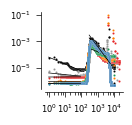

In [27]:
# plot
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax, dd5 = power.plot_power_law_fits_layer_5(ax, d5, prm, cl, pm, pm_fit1, pm_fit2)

# save
plt.savefig("figures/0_validation/4_power/fig2O_L5_pre_power_fit.svg", **savefig_cfg)

## Stats scaling

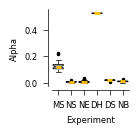

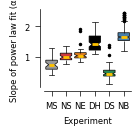

In [28]:
# LFP frequency scaling
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_lfp_freq_scaling_stats_layer_5(ax, dd5, cl)

# save figures
plt.savefig(
    "figures/6_supp/fig2/fig2I_L5_pre_lfp_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Spiking frequency scaling
FIG_SIZE = (1.3, 1.25)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_spiking_freq_scaling_stats_layer_5(ax, dd5, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2P_L5_pre_spiking_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

## Stats SNR

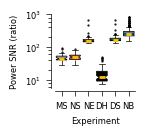

In [30]:
# plot
FIG_SIZE = (1.35, 1.25)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_power_snr_stats_layer_5(ax, d5, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2Q_L5_power_snr.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Layer 6

## Compute

In [31]:
d6 = power.get_psd_data_prepro(
    "L6",
    psd_pre_hv3,  # probe 3
    psd_pre_hs3,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv3[sites_hv3],  # probe 3
    site_ly_hs3[sites_hs3],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

## Power law properties


LFP band
α=-0.6±0.0
α=-0.1±0.0
α=0.0±0.0
α=0.0±0.0
α=-0.0±0.0

Spiking band
α=-1.2±0.2
α=-1.0±0.5
α=-0.3±0.1
α=-0.3±0.2
α=-0.3±0.3

Power SNR
SNR: 46.83792598094198
SNR: 48.268752338530824
SNR: 8.258174715239416
SNR: 77.0628374053796
SNR: 4473.6201428862805


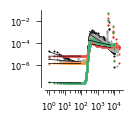

In [32]:
# plot
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax, dd6 = power.plot_power_law_fits(ax, d6, prm, cl, pm, pm_fit1, pm_fit2)

# save
plt.savefig("figures/0_validation/4_power/fig2O_L6_pre_power_fit.svg", **savefig_cfg)

## Stats scaling

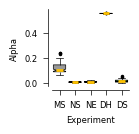

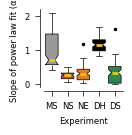

In [33]:
# LFP frequency scaling
FIG_SIZE = (1, 1)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_lfp_freq_scaling_stats(ax, dd6, cl)

# save figures
plt.savefig(
    "figures/6_supp/fig2/fig2I_L6_pre_lfp_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Spiking frequency scaling
FIG_SIZE = (1.3, 1.25)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_spiking_freq_scaling_stats(ax, dd6, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2P_L6_pre_spiking_scaling.svg",
    bbox_inches="tight",
    **savefig_cfg
)

## Stats SNR

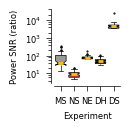

In [34]:
# plot
FIG_SIZE = (1.2, 1.2)
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = power.plot_power_snr_stats(ax, d6, cl)
fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/0_validation/4_power/fig2Q_L6_power_snr.svg",
    bbox_inches="tight",
    **savefig_cfg
)

# Statistics

## Layer-average SNR

In [35]:
def get_power_snr_stats(out_hv_l1, out_hv_l23, out_hv_l4, out_hv_l5, out_hv_l6):
    # calculate power SNR
    snr_hv_l1 = out_hv_l1[0] / out_hv_l1[2]
    snr_hv_l23 = out_hv_l23[0] / out_hv_l23[2]
    snr_hv_l4 = out_hv_l4[0] / out_hv_l4[2]
    snr_hv_l5 = out_hv_l5[0] / out_hv_l5[2]
    snr_hv_l6 = out_hv_l6[0] / out_hv_l6[2]
    # mean
    mean_l1 = np.mean([snr_hv_l1, snr_hv_l23, snr_hv_l4, snr_hv_l5, snr_hv_l6])
    # 95% CI
    ci95_l1 = utils.conf_interv95(
        [snr_hv_l1, snr_hv_l23, snr_hv_l4, snr_hv_l5, snr_hv_l6]
    )
    return mean_l1, ci95_l1

In [144]:
# hv
print("hv")
mean_snr, ci95_snr = get_power_snr_stats(
    out_hv_l1, out_hv_l23, out_hv_l4, out_hv_l5, out_hv_l6
)
print(f"{mean_snr}+-{ci95_snr}")

# hs
print("hs")
mean_snr, ci95_snr = get_power_snr_stats(
    out_hs_l1, out_hs_l23, out_hs_l4, out_hs_l5, out_hs_l6
)
print(f"{mean_snr}+-{ci95_snr}")

# nv
print("nv")
mean_snr, ci95_snr = get_power_snr_stats(
    out_nv_l1, out_nv_l23, out_nv_l4, out_nv_l5, out_nv_l6
)
print(f"{mean_snr}+-{ci95_snr}")

# ns
print("ns")
mean_snr, ci95_snr = get_power_snr_stats(
    out_ns_l1, out_ns_l23, out_ns_l4, out_ns_l5, out_ns_l6
)
print(f"{mean_snr}+-{ci95_snr}")

# ne
print("ne")
mean_snr, ci95_snr = get_power_snr_stats(
    out_ne_l1, out_ne_l23, out_ne_l4, out_ne_l5, out_ne_l6
)
print(f"{mean_snr}+-{ci95_snr}")

# nb
print("nb")
snr_nb_l5 = out_nb_l5[0] / out_nb_l5[2]
print(snr_nb_l5)

hv
21.502885565163886+-11.18199852951585
hs
904.0104973053988+-1322.159584366239
nv
17.920551810306613+-5.663019620341046
ns
12.393803016387562+-6.92950392993122
ne
77.63986838485778+-23.371387005135567
nb
93.05293188618808


# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
